Retentate flow rate (Q_ret_out): 2.3016863715893296 mol/s
Retentate CO2 molar fraction (X_CO2_ret_out): 0.06487680667241966
Permeate flow rate (Q_perm_out): 0.19831362841067035 mol/s
Permeate CO2 molar fraction (X_CO2_perm_out): 0.5076500993914456
Purity of CO2 in permeate: 0.5076500993914456
Recovery of CO2: 0.40269571658559133


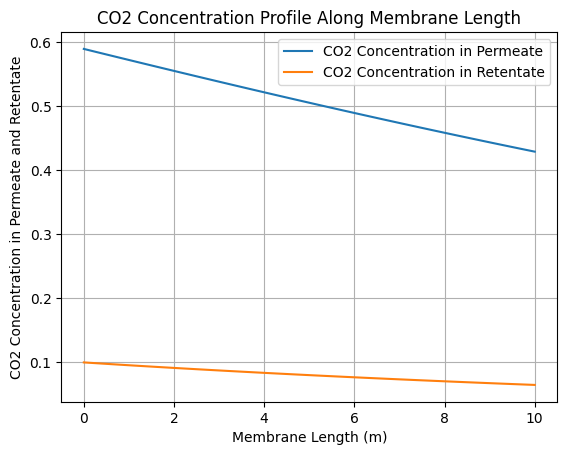

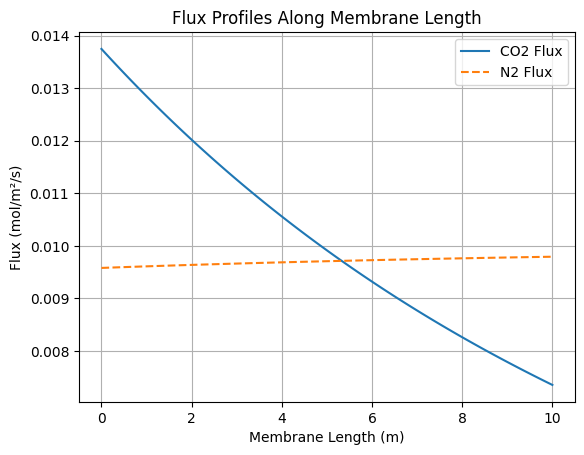

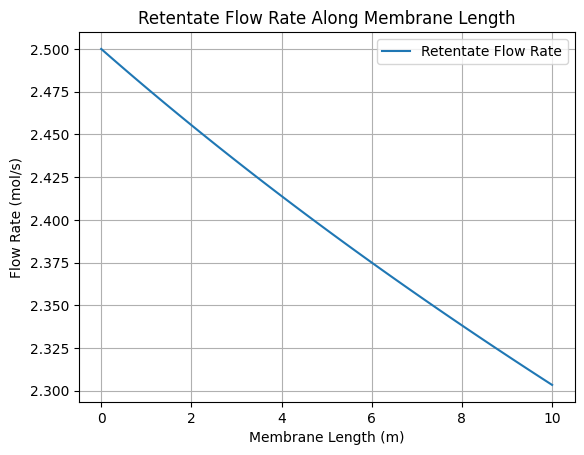

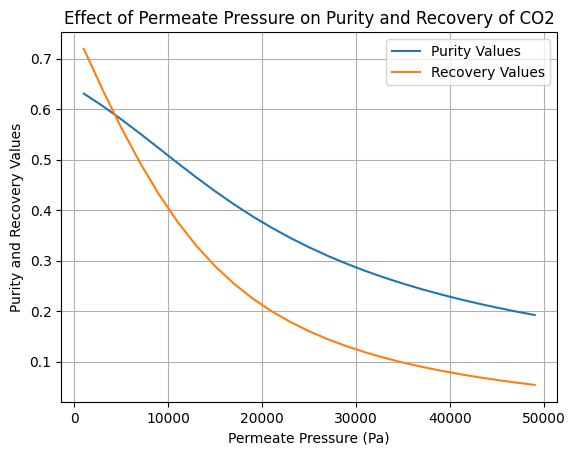

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N_elem = 100
Permeance = 10000 * 3.3464e-10  # mol/(m^2·s·Pa)
P_f, P_perm = 1e5, 10000  # Pa
X_f, Q_f_init, A = 0.1, 2.5, 10  # mol/s, m²
alpha = 30  # Selectivity
beta = P_perm / P_f

# Define single stage process
def single_stage(N_elem, Permeance, P_f, P_perm, X_f, Q_f_init, alpha, beta):
    # Initialize arrays
    X_CO2_f, Q_r, Q_f = np.zeros(N_elem), np.zeros(N_elem), np.zeros(N_elem)
    X_CO2_f[0] = X_f
    Q_f[0] = Q_f_init
    J_CO2, J_N2 = np.zeros(N_elem), np.zeros(N_elem)
    X_prime_CO2_perm_locations = np.zeros(N_elem)
    dA = A / N_elem

    # Single-stage process solver
    for i in range(N_elem):
        term = (alpha - 1) * (beta + X_CO2_f[i])
        discriminant = max(0, (1 + term)**2 - 4 * alpha * beta * (alpha - 1) * X_CO2_f[i])
        X_prime_CO2_perm = (1 + term - np.sqrt(discriminant)) / (2 * beta * (alpha - 1) + 1e-8)
        X_prime_CO2_perm = np.clip(X_prime_CO2_perm, 0, 1)
        X_prime_CO2_perm_locations[i] = X_prime_CO2_perm

        J_CO2[i] = Permeance * (P_f * X_CO2_f[i] - P_perm * X_prime_CO2_perm)
        J_N2[i] = (Permeance / alpha) * (P_f * (1 - X_CO2_f[i]) - P_perm * (1 - X_prime_CO2_perm))
        J_CO2[i], J_N2[i] = max(0, J_CO2[i]), max(0, J_N2[i])

        Q_r[i] = Q_f[i] - (J_CO2[i] + J_N2[i]) * dA
        Q_r[i] = max(0, Q_r[i])
        if i < N_elem - 1:
            X_CO2_f[i + 1] = (X_CO2_f[i] * Q_f[i] - J_CO2[i] * dA) / (Q_r[i] + 1e-8)
            Q_f[i + 1] = Q_r[i]

    # Outputs
    Q_ret_out, X_CO2_ret_out = Q_r[-1], X_CO2_f[-1]
    Q_perm_out = Q_f[0] - Q_ret_out
    X_CO2_perm_out = (X_f * Q_f[0] - X_CO2_ret_out * Q_ret_out) / (Q_perm_out + 1e-8)

    # Purity and recovery
    purity = X_CO2_perm_out
    recovery = Q_perm_out * X_CO2_perm_out / (Q_f[0] * X_f + 1e-8)
    return Q_ret_out, X_CO2_ret_out, Q_perm_out, X_CO2_perm_out, purity, recovery, X_prime_CO2_perm_locations, X_CO2_f, J_N2, J_CO2, Q_f

# Run single stage model
Q_ret_out, X_CO2_ret_out, Q_perm_out, X_CO2_perm_out, purity, recovery, X_prime_CO2_perm_locations, X_CO2_f, J_N2, J_CO2, Q_f = single_stage(
    N_elem, Permeance, P_f, P_perm, X_f, Q_f_init, alpha, beta)

# Print results
print("Retentate flow rate (Q_ret_out):", Q_ret_out, "mol/s")
print("Retentate CO2 molar fraction (X_CO2_ret_out):", X_CO2_ret_out)
print("Permeate flow rate (Q_perm_out):", Q_perm_out, "mol/s")
print("Permeate CO2 molar fraction (X_CO2_perm_out):", X_CO2_perm_out)
print("Purity of CO2 in permeate:", purity)
print("Recovery of CO2:", recovery)

# Plot concentration profiles
X_axis = np.linspace(0, A, N_elem)
plt.plot(X_axis, X_prime_CO2_perm_locations, label='CO2 Concentration in Permeate')
plt.plot(X_axis, X_CO2_f, label='CO2 Concentration in Retentate')
plt.xlabel('Membrane Length (m)')
plt.ylabel('CO2 Concentration in Permeate and Retentate')
plt.title('CO2 Concentration Profile Along Membrane Length')
plt.legend()
plt.grid(True)
plt.show()

# Plot flux profiles
plt.plot(X_axis, J_CO2, label='CO2 Flux')
plt.plot(X_axis, J_N2, label='N2 Flux', linestyle='--')
plt.xlabel('Membrane Length (m)')
plt.ylabel('Flux (mol/m²/s)')
plt.title('Flux Profiles Along Membrane Length')
plt.legend()
plt.grid(True)
plt.show()

# Plot flow rate profile
plt.plot(X_axis, Q_f, label='Retentate Flow Rate')
plt.xlabel('Membrane Length (m)')
plt.ylabel('Flow Rate (mol/s)')
plt.title('Retentate Flow Rate Along Membrane Length')
plt.legend()
plt.grid(True)
plt.show()

# Effect of Permeate Pressure on Purity and Recovery
Permeate_Pressures = np.arange(1000, 50001, 2000)
purity_values = []
recovery_values = []

for P_perm in Permeate_Pressures:
    beta = P_perm / P_f
    _, _, _, _, purity, recovery, _, _, _, _,_ = single_stage(N_elem, Permeance, P_f, P_perm, X_f, Q_f_init, alpha, beta)
    purity_values.append(purity)
    recovery_values.append(recovery)

plt.plot(Permeate_Pressures, purity_values, label='Purity Values')
plt.plot(Permeate_Pressures, recovery_values, label='Recovery Values')
plt.ylabel('Purity and Recovery Values')
plt.xlabel('Permeate Pressure (Pa)')
plt.title('Effect of Permeate Pressure on Purity and Recovery of CO2')
plt.legend()
plt.grid(True)
plt.show()






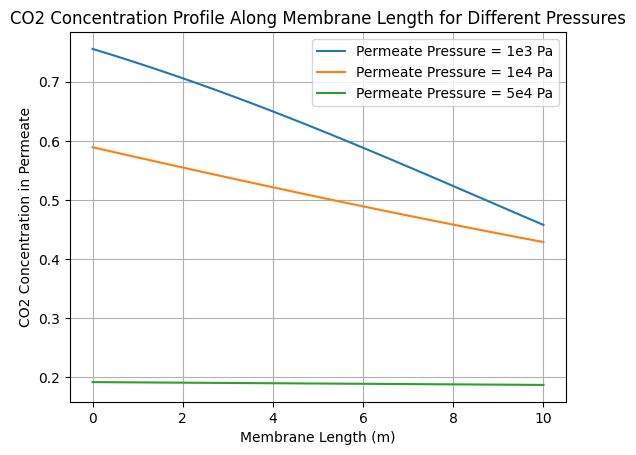

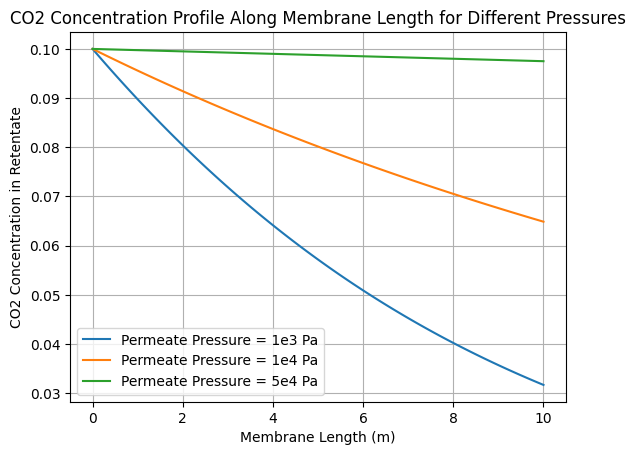

In [5]:
# Testing different permeate pressures
y1 = single_stage(N_elem, Permeance, P_f, P_perm=1e3, X_f=X_f, Q_f_init=Q_f_init, alpha=alpha, beta=1e3 / P_f)
y2 = single_stage(N_elem, Permeance, P_f, P_perm=1e4, X_f=X_f, Q_f_init=Q_f_init, alpha=alpha, beta=1e4 / P_f)
y3 = single_stage(N_elem, Permeance, P_f, P_perm=5e4, X_f=X_f, Q_f_init=Q_f_init, alpha=alpha, beta=5e4 / P_f)

# Plotting the concentration profiles for different pressures
plt.plot(X_axis, y1[6], label='Permeate Pressure = 1e3 Pa')
plt.plot(X_axis, y2[6], label='Permeate Pressure = 1e4 Pa')
plt.plot(X_axis, y3[6], label='Permeate Pressure = 5e4 Pa')
plt.xlabel('Membrane Length (m)')
plt.ylabel('CO2 Concentration in Permeate')
plt.title('CO2 Concentration Profile Along Membrane Length for Different Pressures')
plt.legend()
plt.grid(True)
plt.show()

# Testing different permeate pressures
y1 = single_stage(N_elem, Permeance, P_f, P_perm=1e3, X_f=X_f, Q_f_init=Q_f_init, alpha=alpha, beta=1e3 / P_f)
y2 = single_stage(N_elem, Permeance, P_f, P_perm=1e4, X_f=X_f, Q_f_init=Q_f_init, alpha=alpha, beta=1e4 / P_f)
y3 = single_stage(N_elem, Permeance, P_f, P_perm=5e4, X_f=X_f, Q_f_init=Q_f_init, alpha=alpha, beta=5e4 / P_f)

# Plotting the concentration profiles for different pressures
plt.plot(X_axis, y1[7], label='Permeate Pressure = 1e3 Pa')
plt.plot(X_axis, y2[7], label='Permeate Pressure = 1e4 Pa')
plt.plot(X_axis, y3[7], label='Permeate Pressure = 5e4 Pa')
plt.xlabel('Membrane Length (m)')
plt.ylabel('CO2 Concentration in Retentate')
plt.title('CO2 Concentration Profile Along Membrane Length for Different Pressures')
plt.legend()
plt.grid(True)
plt.show()



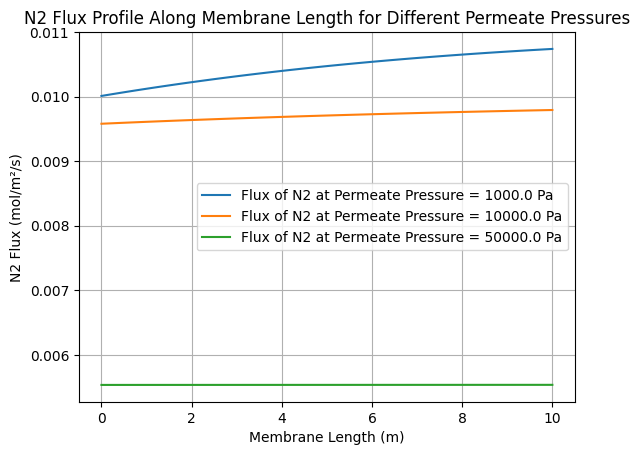

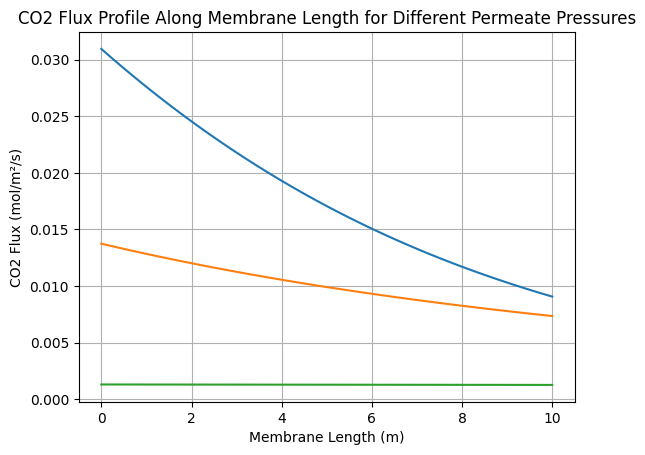

In [7]:
# Define parameters and initialize lists
five_testing_values = [1e3, 1e4, 5e4]
flux_n2 = []
flux_co2 = []

# X-axis for plotting
X_axis = np.linspace(0, A, N_elem)

# Loop through each permeate pressure and plot flux profiles
for P_perm in five_testing_values: 
    beta = P_perm / P_f
    _, _, _, _, _, _, _, _, J_N2, J_CO2, _ = single_stage(N_elem, Permeance, P_f, P_perm, X_f, Q_f_init, alpha, beta)
    
    # Append the flux data to lists
    flux_n2.append(J_N2)
    flux_co2.append(J_CO2)
    
    # Plot N2 flux for each permeate pressure
    plt.plot(X_axis, J_N2, label=f"Flux of N2 at Permeate Pressure = {P_perm:.1f} Pa")

# Add plot labels and legend
plt.xlabel('Membrane Length (m)')
plt.ylabel('N2 Flux (mol/m²/s)')
plt.title('N2 Flux Profile Along Membrane Length for Different Permeate Pressures')
plt.legend()
plt.grid(True)
plt.show()

X_axis = np.linspace(0, A, N_elem)

# Loop through each permeate pressure and plot flux profiles
for P_perm in five_testing_values: 
    beta = P_perm / P_f
    _, _, _, _, _, _, _, _, J_N2, J_CO2, _ = single_stage(N_elem, Permeance, P_f, P_perm, X_f, Q_f_init, alpha, beta)
    
    # Append the flux data to lists
    flux_n2.append(J_N2)
    flux_co2.append(J_CO2)

    plt.plot(X_axis, J_CO2, label=f"Flux of CO2 at Permeate Pressure = {P_perm:.1f} Pa")

plt.xlabel('Membrane Length (m)')
plt.ylabel('CO2 Flux (mol/m²/s)')
plt.title('CO2 Flux Profile Along Membrane Length for Different Permeate Pressures')
plt.grid(True)
plt.show()



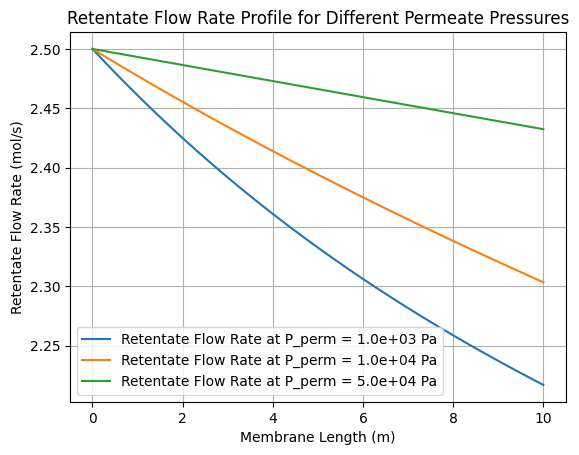

In [8]:
# Define the three testing permeate pressures
three_testing_values = [1e3, 1e4, 5e4]
flow_rate_profiles = []

# X-axis for membrane length
X_axis = np.linspace(0, A, N_elem)

# Run the single stage model for each permeate pressure and collect the retentate flow rates
for P_perm in three_testing_values:
    beta = P_perm / P_f
    Q_ret_out, X_CO2_ret_out, Q_perm_out, X_CO2_perm_out, purity, recovery, X_prime_CO2_perm_locations, X_CO2_f, J_N2, J_CO2, Q_f = single_stage(
        N_elem, Permeance, P_f, P_perm, X_f, Q_f_init, alpha, beta
    )
    flow_rate_profiles.append(Q_f)  # Store the retentate flow rate profile for each permeate pressure

# Plot flow rate profiles for different permeate pressures
for i, P_perm in enumerate(three_testing_values):
    plt.plot(X_axis, flow_rate_profiles[i], label=f'Retentate Flow Rate at P_perm = {P_perm:.1e} Pa')

# Add plot labels, title, and legend
plt.xlabel('Membrane Length (m)')
plt.ylabel('Retentate Flow Rate (mol/s)')
plt.title('Retentate Flow Rate Profile for Different Permeate Pressures')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Double Stage Process 

N_elem = 100
Permeance = 10000 * 3.3464e-10  # mol/(m^2·s·Pa)
P_f, P_perm = 1e5, 20000  # Pa
X_f, Q_f_init, A = 0.50765, 0.1983136 , 5  # mol/s, m²
alpha = 30  # Selectivity
beta = P_perm / P_f

Q_ret_out2, X_CO2_ret_out2, Q_perm_out2, X_CO2_perm_out2, purity2, recovery2, X_prime_CO2_perm_locations, X_CO2_f, J_N2, J_CO2, Q_f = single_stage(
    N_elem, Permeance, P_f, P_perm, X_f, Q_f_init, alpha, beta)

print("Retentate flow rate (Q_ret_out):", Q_ret_out2, "mol/s")
print("Retentate CO2 molar fraction (X_CO2_ret_out):", X_CO2_ret_out2)
print("Permeate flow rate (Q_perm_out):", Q_perm_out2, "mol/s")
print("Permeate CO2 molar fraction (X_CO2_perm_out):", X_CO2_perm_out2)
print("Purity of CO2 in permeate:", purity2)
print("Recovery of CO2:", recovery2)
print("Global Recovery: ",recovery2*0.402695)

Retentate flow rate (Q_ret_out): 0.057849746079774694 mol/s
Retentate CO2 molar fraction (X_CO2_ret_out): 0.02712650089660375
Permeate flow rate (Q_perm_out): 0.1404638539202253 mol/s
Permeate CO2 molar fraction (X_CO2_perm_out): 0.7055525534124844
Purity of CO2 in permeate: 0.7055525534124844
Recovery of CO2: 0.9844122647129623
Global Recovery:  0.39641789693858637


In [ ]:
#Double Stage Process Graphs 

#CO2 Concentration Profile with different Permeate Pressures 

#Flux Rate with different Permeate Pressures 

#Flow Rate with different Permeate Pressures 

#Purity and Recovery with different Permeate Pressures 

In [ ]:
N_elem=100
Permeance=10000 * 3.3464e-10 
P_f, P_perm, P_perm2 = 1e5, 10000, 20000
X_f, Q_f_init, A, A2 = 0.1, 2.5, 10, 5
alpha=30
beta, beta2=P_perm/P_f, P_perm2/P_f